# Find A Raster Tile

**Goal**: Find the raster tile your pit falls in.

**Approach**: 
1. Grab the pit location from the a pit layer in the database
2. Perform an interest on all raster tiles with the pit location 
3. Convert the raster to tiff 
4. Dump to memory and plot 


Grabbing rasters that overlap on the point POINT (745458 4322762)
Found 4 rasters touching the point POINT (745458 4322762)


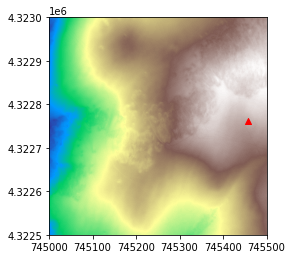

In [6]:
from snowxsql.db import get_db
from snowxsql.data import RasterData, LayerData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape
from rasterio import MemoryFile
import matplotlib.pyplot as plt
import geopandas as gpd

# PIT Site Identifier
site_id = '5S31'

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)
datasets = []

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id == site_id)
layers = q.all()

# Grab the pit location from a single layer
p = layers[0].geometry
p_shp = to_shape(p)

print('Grabbing rasters that overlap on the point {}'.format(p_shp))
rasters = session.query(func.ST_AsTiff(RasterData.raster)).filter(gfunc.ST_Intersects(RasterData.raster, p)).all()

print("Found {} rasters touching the point {}".format(len(rasters), p_shp))

fig,ax = plt.subplots()

for tiff in rasters:
    bdata = bytes(tiff[0])

    with MemoryFile() as tmpfile:
        tmpfile.write(bdata)
        d = tmpfile.open()

        show(d.read(1), ax=ax, transform=d.transform, cmap='terrain')
        datasets.append(d)

gpd.GeoSeries(p_shp).plot(ax=ax, color='r', marker='^')

for d in datasets:
    d.close()

